Mount the Google Drive to upload the files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import umap.umap_ as umap
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.manifold import TSNE


Load and Merge Order Book Files

In [ ]:
def load_multiple_orderbooks(folder_path):
    files = sorted(glob.glob(folder_path + "/*.txt"))
    all_dfs = []
    for file in files:
        df = pd.read_csv(file)
        df['Time'] = pd.to_datetime(df['Time'].str.split('+').str[0])
        all_dfs.append(df)
    merged_df = pd.concat(all_dfs).sort_values(by='Time').reset_index(drop=True)
    return merged_df

orderbook_df = load_multiple_orderbooks("/content/drive/MyDrive/depth20")
print("Orderbook data loaded successfully. Shape:", orderbook_df.shape)
orderbook_df.head()


 Load and Merge Trade Files

In [ ]:
def load_multiple_trades(folder_path):
    files = sorted(glob.glob(folder_path + "/*.txt"))
    all_dfs = []
    for file in files:
        df = pd.read_csv(file)
        df['Time'] = pd.to_datetime(df['Time'].str.split('+').str[0])
        all_dfs.append(df)
    merged_df = pd.concat(all_dfs).sort_values(by='Time').reset_index(drop=True)
    return merged_df

trades_df = load_multiple_trades("/content/drive/MyDrive/aggTrade")
print("Trade data loaded successfully. Shape:", trades_df.shape)
trades_df.head()


Feature Engineering

In [ ]:
# Step 1: Create base features DataFrame
features = pd.DataFrame()
features['Time'] = orderbook_df['Time']


In [ ]:
# Step 2: Mid price and spread
bid_1 = orderbook_df['BidPriceL1']
ask_1 = orderbook_df['AskPriceL1']
bid_qty_1 = orderbook_df['BidQtyL1']
ask_qty_1 = orderbook_df['AskQtyL1']

features['mid_price'] = (bid_1 + ask_1) / 2
features['spread'] = ask_1 - bid_1

features[['Time', 'mid_price', 'spread']].head()


In [ ]:
# Step 3: Imbalance and microprice
features['imbalance_lvl1'] = (bid_qty_1 - ask_qty_1) / (bid_qty_1 + ask_qty_1)
features['microprice'] = (bid_1 * ask_qty_1 + ask_1 * bid_qty_1) / (bid_qty_1 + ask_qty_1)

features[['Time', 'imbalance_lvl1', 'microprice']].head()


In [ ]:
# Step 4: Cumulative bid and ask quantity
bid_qty_cols = [col for col in orderbook_df.columns if 'BidQtyL' in col]
ask_qty_cols = [col for col in orderbook_df.columns if 'AskQtyL' in col]

features['cum_bid_qty'] = orderbook_df[bid_qty_cols].sum(axis=1)
features['cum_ask_qty'] = orderbook_df[ask_qty_cols].sum(axis=1)

features[['Time', 'cum_bid_qty', 'cum_ask_qty']].head()


In [ ]:
# Step 5: Log returns and rolling volatility
features['log_return'] = np.log(features['mid_price']).diff()
features['volatility_10s'] = features['log_return'].rolling(window=10).std()
features['volatility_30s'] = features['log_return'].rolling(window=30).std()

features[['Time', 'log_return', 'volatility_10s', 'volatility_30s']].dropna().head()


In [ ]:
# Step 6: Resample trade data to get aggregated volume and price every 1 second
trades_df.set_index('Time', inplace=True)

resampled = trades_df.resample('1S').agg({
    'Price': 'mean',
    'Quantity': 'sum',
    'IsMarketMaker': 'mean',
    'NumTrades': 'sum'
}).fillna(0).reset_index()

resampled.head()


In [ ]:
# Step 7: Merge resampled trade data with orderbook features
features = pd.merge_asof(features.sort_values('Time'),
                         resampled.sort_values('Time'),
                         on='Time', direction='backward')

features[['Time', 'Price', 'Quantity', 'NumTrades']].head()


In [ ]:
# Step 8: Rolling volume features
features['rolling_volume_10s'] = features['Quantity'].rolling(10).sum()
features['rolling_volume_30s'] = features['Quantity'].rolling(30).sum()

features[['Time', 'rolling_volume_10s', 'rolling_volume_30s']].dropna().head()


In [ ]:
# Step 8: Rolling volume features
features['rolling_volume_10s'] = features['Quantity'].rolling(10).sum()
features['rolling_volume_30s'] = features['Quantity'].rolling(30).sum()

features[['Time', 'rolling_volume_10s', 'rolling_volume_30s']].dropna().head()


In [ ]:
# Step 9: Final check on the shape of processed dataset
features = features.dropna()
print("Feature engineering complete. Final dataset shape:", features.shape)
features.head()


Normalize Features

In [ ]:
from sklearn.preprocessing import StandardScaler

feature_cols = ['mid_price', 'spread', 'imbalance_lvl1', 'microprice',
                'cum_bid_qty', 'cum_ask_qty', 'log_return', 'volatility_10s',
                'volatility_30s', 'Quantity', 'rolling_volume_10s', 'rolling_volume_30s']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features[feature_cols])
print("Feature normalization complete. Shape:", X_scaled.shape)


PCA ( Principal Component Analysis)

In [ ]:
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)

KMeans Clustering

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
features['kmeans_cluster'] = kmeans.fit_predict(X_pca)

print("KMeans clustering complete. Cluster distribution:")
print(features['kmeans_cluster'].value_counts())

Gaussian Mixture Model

In [ ]:
gmm = GaussianMixture(n_components=4, random_state=42)
features['gmm_cluster'] = gmm.fit_predict(X_pca)

print("GMM clustering complete. Cluster distribution:")
print(features['gmm_cluster'].value_counts())

HDBSCAN

In [ ]:
hdb = hdbscan.HDBSCAN(min_cluster_size=20)
features['hdbscan_cluster'] = hdb.fit_predict(X_scaled)

print("HDBSCAN clustering complete. Cluster distribution:")
print(features['hdbscan_cluster'].value_counts())


UMAP

In [22]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

features['umap_x'] = X_umap[:, 0]
features['umap_y'] = X_umap[:, 1]

print("UMAP dimensionality reduction complete. Shape:", X_umap.shape)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


UMAP dimensionality reduction complete. Shape: (338489, 2)


Regime Analysis

In [24]:
# Compare volatility across clusters
cluster_volatility = features.groupby('hdbscan_cluster')['volatility_10s'].mean()

print("Average 10s volatility per HDBSCAN cluster:")
print(cluster_volatility.sort_values(ascending=False))


Average 10s volatility per HDBSCAN cluster:
hdbscan_cluster
 6     0.000160
-1     0.000111
 4     0.000089
 3     0.000087
 1     0.000082
 7     0.000070
 0     0.000067
 5     0.000066
 18    0.000060
 2     0.000059
 8     0.000059
 21    0.000057
 17    0.000051
 16    0.000046
 12    0.000043
 11    0.000042
 13    0.000038
 9     0.000035
 10    0.000035
 20    0.000033
 15    0.000031
 19    0.000030
 14    0.000020
Name: volatility_10s, dtype: float64


Visualize UMAP Clusters

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


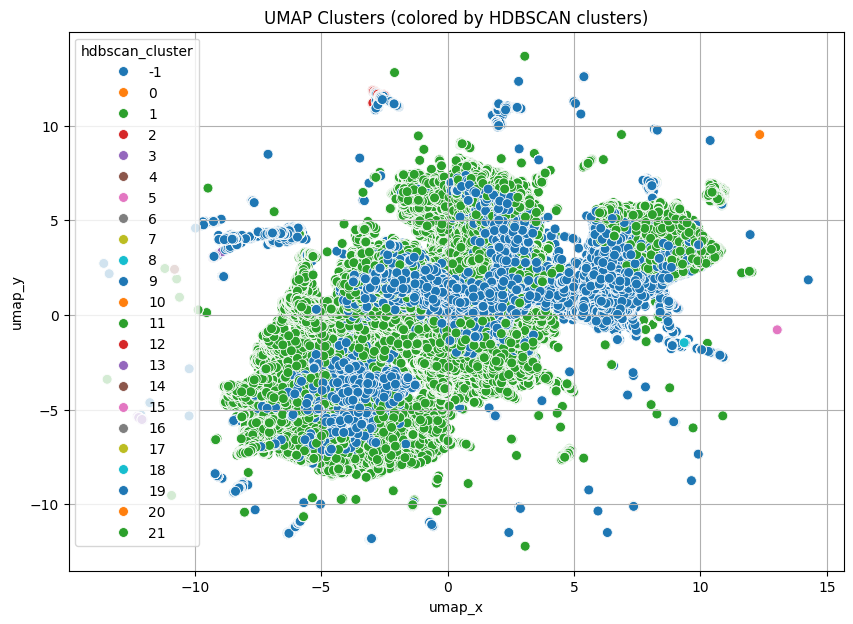

In [25]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='umap_x', y='umap_y', hue='hdbscan_cluster', data=features, palette='tab10', s=50)
plt.title("UMAP Clusters (colored by HDBSCAN clusters)")
plt.grid(True)
plt.show()


Plot Mid Price with Clusters

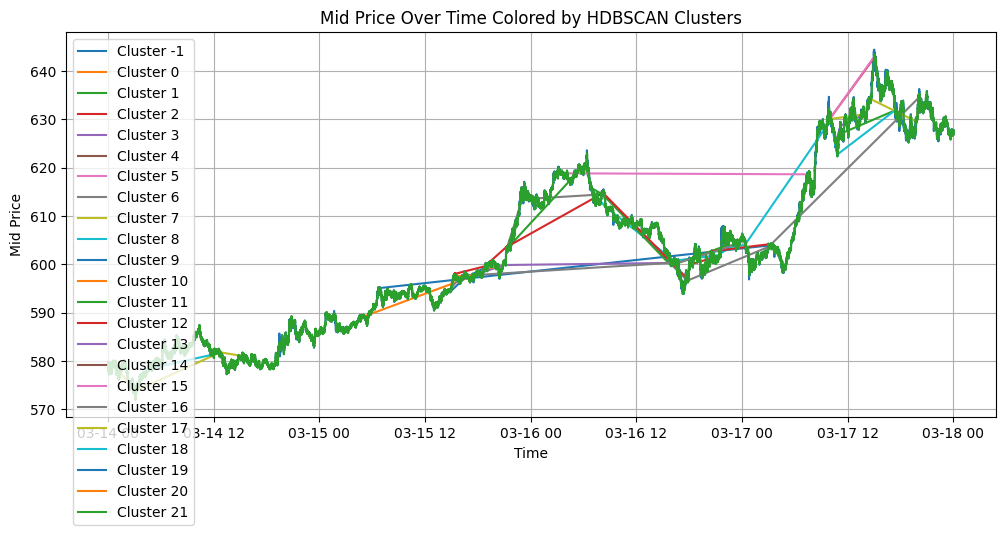

In [26]:
plt.figure(figsize=(12, 5))
for cluster in sorted(features['hdbscan_cluster'].unique()):
    cluster_data = features[features['hdbscan_cluster'] == cluster]
    plt.plot(cluster_data['Time'], cluster_data['mid_price'], label=f'Cluster {cluster}')

plt.xlabel("Time")
plt.ylabel("Mid Price")
plt.title("Mid Price Over Time Colored by HDBSCAN Clusters")
plt.legend()
plt.grid(True)
plt.show()


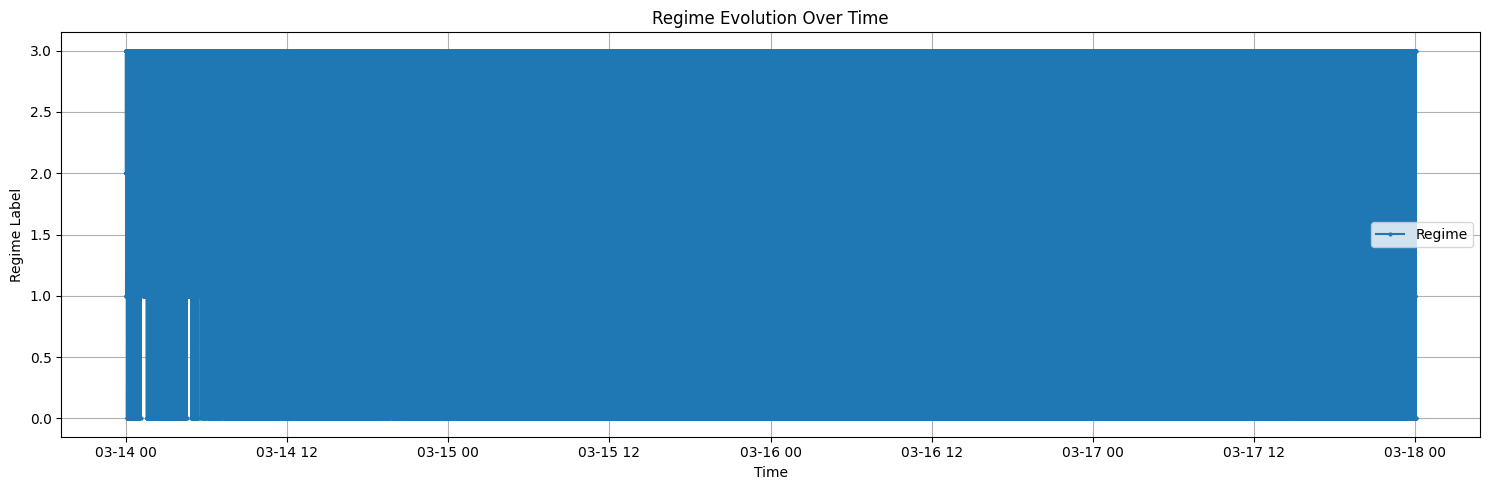

In [29]:
# Choose which clustering result to visualize
cluster_col = 'kmeans_cluster'  # Change to 'kmeans_cluster', 'gmm_cluster', etc. if needed

plt.figure(figsize=(15, 5))
plt.plot(features['Time'], features[cluster_col], marker='o', linestyle='-', markersize=2, label='Regime')
plt.title("Regime Evolution Over Time")
plt.xlabel("Time")
plt.ylabel("Regime Label")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

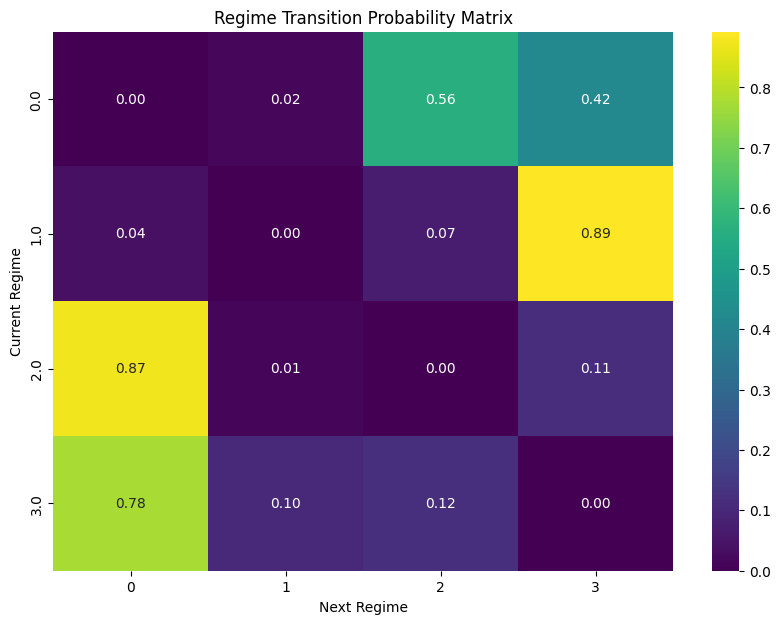

In [31]:
# Use HDBSCAN cluster results (or change to any other cluster column)
cluster_col = 'kmeans_cluster'

# Drop consecutive duplicates to only record regime switches
regime_sequence = features[cluster_col].copy()
regime_sequence = regime_sequence[regime_sequence.shift(1) != regime_sequence]

# Build transition count matrix
transition_counts = pd.crosstab(regime_sequence.shift(), regime_sequence)

# Convert to transition probability matrix
transition_probs = transition_counts.div(transition_counts.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(transition_probs, annot=True, cmap="viridis", fmt=".2f")
plt.title("Regime Transition Probability Matrix")
plt.xlabel("Next Regime")
plt.ylabel("Current Regime")
plt.show()